How to run a stellar evolution code
====================

Here we will generate initial conditions for a stellar evolution code. We will adopt a parametrized stellar evolution code.

For reference you can read chapter 3 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate inital conditions (mass-function)
- how to run a parametrized stellar evolution code
- channels and data transfer
- plotting results

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units

We start by setting up a simulation by specifying the initial mass function. What would you say is the biggest difference between these IMFs?

mean-mass for Kroupa= 0.652007872902 MSun
mean-mass for Salpeter= 0.37162071778 MSun


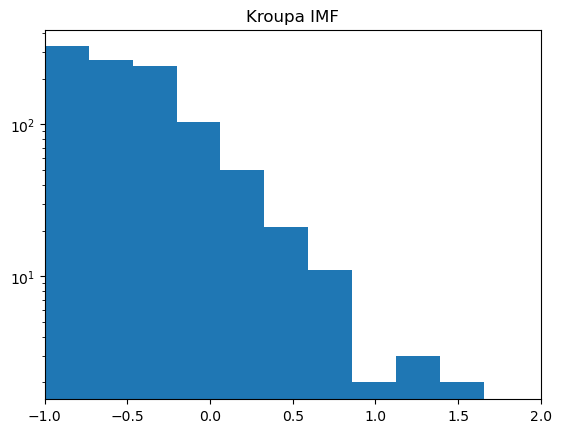

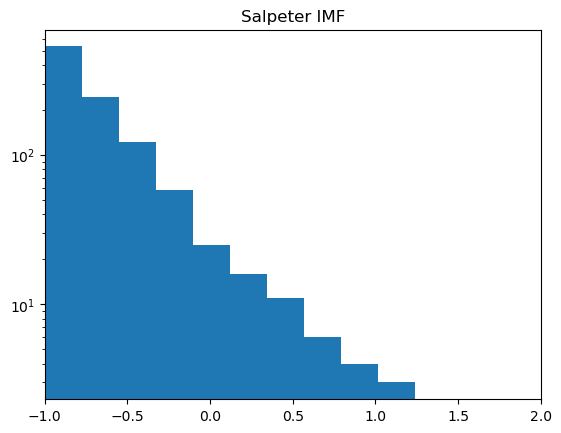

In [2]:
from amuse.datamodel import Particles
n_stars = 1024
mmin = 0.1 | units.MSun
mmax = 100 | units.MSun

from amuse.lab import new_kroupa_mass_distribution
mkroupa = new_kroupa_mass_distribution(n_stars,
                                           mass_min=mmin, 
                                           mass_max=mmax)
k_stars = Particles(mass=mkroupa)
k_stars_z = k_stars.copy()
from amuse.lab import new_salpeter_mass_distribution
msalpeter = new_salpeter_mass_distribution(n_stars, 
                                           mass_min=mmin, 
                                           mass_max=mmax)
s_stars = Particles(mass=msalpeter)
s_stars_z = s_stars.copy()
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))

pyplot.hist(numpy.log10(k_stars.mass.value_in(units.MSun))) #Note that this is a log scale: 2 corresponds to 100x MSun
pyplot.title('Kroupa IMF')
pyplot.yscale('log')
pyplot.xlim(-1, 2)
pyplot.figure()
pyplot.hist(numpy.log10(s_stars.mass.value_in(units.MSun)))
pyplot.title('Salpeter IMF')
pyplot.yscale('log')
pyplot.xlim(-1, 2)
pyplot.show()

Now that the mass functions are determined, we can evolve the stars in time. For this we start two stellar evolution codes, both parametrized, and evolve the stars in time.

In [3]:
from amuse.community.seba.interface import SeBa
def start_stellar_code(stars, z):
    stellar = SeBa()
    print("Metallicity before setting:", stellar.get_metallicity())
    stellar.parameters.metallicity = z
    print("Metallicity after setting:", stellar.get_metallicity())
    stellar.particles.add_particles(stars)
    channels = {"to_stars": stellar.particles.new_channel_to(stars), 
                "to_stellar": stars.new_channel_to(stellar.particles),
                "to_stars_z": stellar.particles.new_channel_to(stars)}
    return stellar, channels
kstellar, kchannels = start_stellar_code(k_stars, 0.02)
sstellar, schannels = start_stellar_code(s_stars, 0.02)

Metallicity before setting: 0.02
Metallicity after setting: 0.02
Metallicity before setting: 0.02
Metallicity after setting: 0.02


Now the stellar evolution code are declared. Now evolve in time and calculate the mean mass as a function of time.

In [4]:
times = 10**numpy.arange(0.0, 4.0, 0.1) | units.Myr
mmean = []
lsum = []
Tsum = []
for time in times:
    kstellar.evolve_model(time)
    kchannels["to_stars"].copy()
    sstellar.evolve_model(time)
    schannels["to_stars"].copy()
    mmean.append(numpy.mean(k_stars.mass)/numpy.mean(s_stars.mass))
    lsum.append(numpy.sum(k_stars.luminosity)/numpy.sum(s_stars.luminosity))
    Tsum.append(numpy.sum(k_stars.temperature)/numpy.sum(s_stars.temperature))
kstellar.stop()
sstellar.stop()
print("mean-mass for Kroupa=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))
print("total L for Kroupa=", numpy.sum(k_stars.luminosity))
print("total L for Salpeter=", numpy.sum(s_stars.luminosity))
print("total Temp for Kroupa=", numpy.sum(k_stars.temperature))
print("total Temp for Salpeter=", numpy.sum(s_stars.temperature))

mean-mass for Kroupa= 0.389325165409 MSun
mean-mass for Salpeter= 0.246597881748 MSun
total L for Kroupa= 249.49365786 LSun
total L for Salpeter= 45.8303940925 LSun
total Temp for Kroupa= 5119900.27054 K
total Temp for Salpeter= 3489111.27183 K


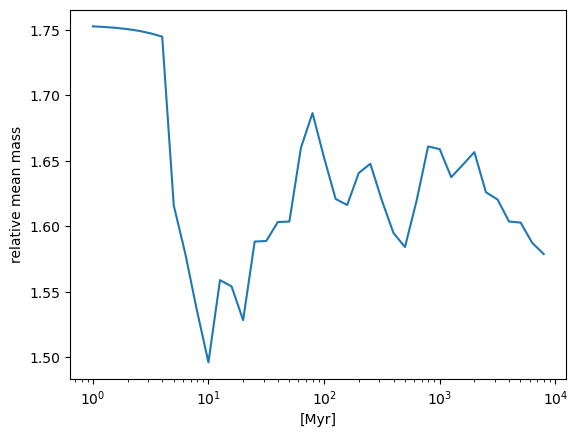

In [5]:
from amuse.plot import plot
plot(times, mmean)
pyplot.ylabel("relative mean mass")
pyplot.semilogx()
pyplot.show()

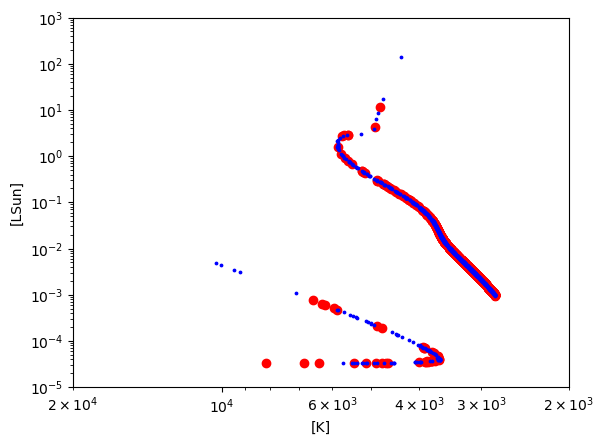

In [6]:
from amuse.plot import scatter
scatter(s_stars.temperature, s_stars.luminosity, c='r')
scatter(k_stars.temperature, k_stars.luminosity, c='b', s=3)
pyplot.xlim(2.e+4, 2000)
pyplot.ylim(1.e-5, 1000)
pyplot.loglog()
pyplot.show()

You have calculated the evolution of a stellar population with solar metalicity.

Assignments and questions:
---------------

### Assignment 1:
Run the notebook and describe the evolution of the relative mean stellar mass. Why does it drop with time?

### Assignment 2:
Compare the mean mass of two stellar populations with different metalicity, 0.02 (solar) and 0.002 (one tenth times solar) but the same stellar masses.

### Question 1:
Is there a difference in the number of compact objects (white dwarfs, neutron stars, black holes; these types are defined [here](https://github.com/amusecode/amuse/blob/main/src/amuse/units/units.py), and e.g. 1.|stellar_type corresponds to a main sequene star) in the populations with different initial mass functions, and with different metallicities, and is this difference statistically significant?

Is a similar difference also noticeable in the number of main sequence stars?

### Assignment 3:
Calculate, instead of the mean mass, the total luminosity and luminosity-weighted temperature ($T_{LW}=(\Sigma_iL_iT_i)/(\Sigma_iL_i)$, the effective color of the integrated stellar population) of the entire population of stars as a function of time.

Make a plot of these parameters for both mass functions, and both metallicities. 

### Question 4:
Can one, based on observational differences in luminosity and integrated temperature, make a distinction between the two mass functions?

In [7]:
#A1: The mean mass of the kroupa distribution is substantially higher than that of the salpeter distribution, sometimes even
#twice as high, though it moves towards the mean mass of the salpeter distribution over time. This implies that the 
#ratio between the two sets of mean masses approaches unity. Though the stellar evolution codes may begin differently and 
#have different evolutions, they both move towards the same mean mass value after ~10**4 Myrs.

In [8]:
#A2: Mean masses of 
print("mean-mass for Kroupa, solar z=", numpy.mean(k_stars.mass))
print("mean-mass for Salpeter=", numpy.mean(s_stars.mass))

mean-mass for Kroupa, solar z= 0.389325165409 MSun
mean-mass for Salpeter= 0.246597881748 MSun


In [9]:
ktype = k_stars.stellar_type.value_in(units.stellar_type)
count_ktype = numpy.bincount(ktype)

#for i in ktype:
    #k = count_ktype[i+1]
    #print('There are', k, 'values of', i)
    
try:
    print("In the Kroupa distribution, z=0.02,")
    print("There are", count_ktype[1], "Main-Sequence Stars")
    print("There are", count_ktype[10], "Helium White Dwarfs")
    print("There are", count_ktype[11], "C/O White Dwarfs")
    print("There are", count_ktype[12], "O/Ne White Dwarfs")
    print("There are", count_ktype[13], "Neutron Stars")
    print("There are", count_ktype[14], "Black Holes")
except IndexError:
    print("Oh for the love of god")

stype = s_stars.stellar_type.value_in(units.stellar_type)
count_stype = numpy.bincount(stype)

try:
    print("")
    print("In the Salpeter distribution, z=0.02,")
    print("There are", count_stype[1], "Main-Sequence Stars")
    print("There are", count_stype[10], "Helium White Dwarfs")
    print("There are", count_stype[11], "C/O White Dwarfs")
    print("There are", count_stype[12], "O/Ne White Dwarfs")
    print("There are", count_stype[13], "Neutron Stars")
    print("There are", count_stype[14], "Black Holes")
except IndexError:
    #print("These are not the droids you are looking for")
    print("There was an index error; no further objects were found")

In the Kroupa distribution, z=0.02,
There are 925 Main-Sequence Stars
There are 0 Helium White Dwarfs
There are 85 C/O White Dwarfs
There are 0 O/Ne White Dwarfs
There are 3 Neutron Stars
There are 4 Black Holes

In the Salpeter distribution, z=0.02,
There are 974 Main-Sequence Stars
There are 0 Helium White Dwarfs
There are 39 C/O White Dwarfs
There are 3 O/Ne White Dwarfs
There are 4 Neutron Stars
There was an index error; no further objects were found


In [10]:
kstellar_z, kchannels_z = start_stellar_code(k_stars_z, 0.002)

mmean_z = []
lsum_z = []
tsum_z = []
for time in times:
    kstellar_z.evolve_model(time)
    kchannels_z["to_stars_z"].copy()
    mmean_z.append(numpy.mean(k_stars_z.mass))
    lsum_z.append(numpy.sum(k_stars_z.luminosity))
    tsum_z.append(numpy.sum(k_stars_z.temperature))
kstellar_z.stop()

print("mean-mass for Kroupa, 1/10 solar z=", numpy.mean(k_stars_z.mass))

Metallicity before setting: 0.02
Metallicity after setting: 0.002
mean-mass for Kroupa, 1/10 solar z= 0.393937732441 MSun


In [11]:
sstellar_z, schannels_z = start_stellar_code(s_stars_z, 0.002)

mmean_zs = []
lsum_zs = []
tsum_zs = []
for time in times:
    sstellar_z.evolve_model(time)
    schannels_z["to_stars_z"].copy()
    mmean_zs.append(numpy.mean(s_stars_z.mass))
    lsum_zs.append(numpy.sum(s_stars_z.luminosity))
    tsum_zs.append(numpy.sum(s_stars_z.temperature))
sstellar_z.stop()

print("mean-mass for Salpeter, 1/10 solar z=", numpy.mean(s_stars_z.mass))

Metallicity before setting: 0.02
Metallicity after setting: 0.002
mean-mass for Salpeter, 1/10 solar z= 0.245473667433 MSun


In [12]:
ktype_z = k_stars_z.stellar_type.value_in(units.stellar_type)
count_ktype_z = numpy.bincount(ktype_z)

try:    
    print("In the Kroupa distribution, z=0.002,")
    print("There are", count_ktype_z[1], "Main-Sequence Stars")
    print("There are", count_ktype_z[10], "Helium White Dwarfs")
    print("There are", count_ktype_z[11], "C/O White Dwarfs")
    print("There are", count_ktype_z[12], "O/Ne White Dwarfs")
    print("There are", count_ktype_z[13], "Neutron Stars")
    print("There are", count_ktype_z[14], "Black Holes")
except IndexError:
    print("There are 0 Black Holes")

stype_z = s_stars_z.stellar_type.value_in(units.stellar_type)
count_stype_z = numpy.bincount(stype_z)

try:
    print("")
    print("In the Salpeter distribution, z=0.002,")
    print("There are", count_stype_z[1], "Main-Sequence Stars")
    print("There are", count_stype_z[10], "Helium White Dwarfs")
    print("There are", count_stype_z[11], "C/O White Dwarfs")
    print("There are", count_stype_z[12], "O/Ne White Dwarfs")
    print("There are", count_stype_z[13], "Neutron Stars")
    print("There are", count_stype_z[14], "Black Holes")
except IndexError:
    print("There are 0 O/Ne White Dwarfs")
    print("There are 0 Neutron Stars")
    print("There are 0 Black Holes")

In the Kroupa distribution, z=0.002,
There are 904 Main-Sequence Stars
There are 0 Helium White Dwarfs
There are 105 C/O White Dwarfs
There are 4 O/Ne White Dwarfs
There are 3 Neutron Stars
There are 4 Black Holes

In the Salpeter distribution, z=0.002,
There are 969 Main-Sequence Stars
There are 0 Helium White Dwarfs
There are 46 C/O White Dwarfs
There are 2 O/Ne White Dwarfs
There are 5 Neutron Stars
There are 1 Black Holes


In [13]:
#Q1: There is a certainly a difference between the mass functions, and a small difference between the metallicities. 
#The Kroupa distribution has more compact objects than the Salpeter distribution; there are fewer white dwarfs and black 
#holes in the higher metallicity, but I do not think it is enough to be statistically significant.
#The number of main-sequence stars seems to be similar; there are slightly more in the z=0.02 distribution.
#I think this difference could be statistically significant, considering how many stars are in the average star-forming 
#region (much higher than 1024).

In [14]:
#A3: 

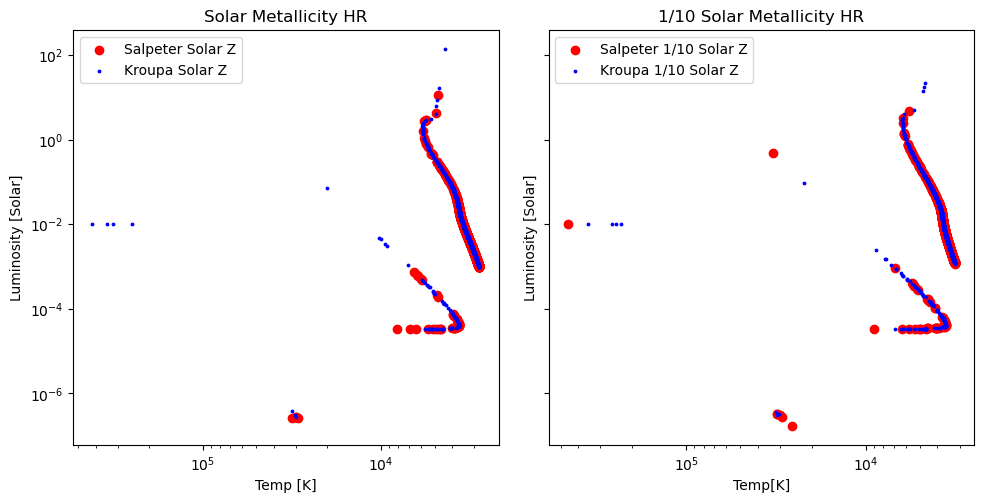

In [16]:
fig,ax = pyplot.subplots(1,2, sharey=True)
fig.set_size_inches(10,5)
fig.tight_layout(pad=2.0)

#ax.set_xlim(0.0,1.5)
#ax[0].semilogx()

ax[0].set_title('Solar Metallicity HR')
ax[0].set_xlabel('Temp [K]')
ax[0].set_ylabel('Luminosity [Solar]')
ax[0].loglog()
ax[0].invert_xaxis()

ax[1].set_title('1/10 Solar Metallicity HR')
ax[1].set_xlabel('Temp[K]')
ax[1].set_ylabel('Luminosity [Solar]')
ax[1].loglog()
ax[1].invert_xaxis()

ax[0].scatter(s_stars.temperature.value_in(units.K), s_stars.luminosity.value_in(units.LSun), c='r', label='Salpeter Solar Z')
ax[0].scatter(k_stars.temperature.value_in(units.K), k_stars.luminosity.value_in(units.LSun), c='b', s=3, label='Kroupa Solar Z')
ax[0].legend(loc=0)

ax[1].scatter(s_stars_z.temperature.value_in(units.K), s_stars_z.luminosity.value_in(units.LSun), c='r', label='Salpeter 1/10 Solar Z')
ax[1].scatter(k_stars_z.temperature.value_in(units.K), k_stars_z.luminosity.value_in(units.LSun), c='b', s=3, label='Kroupa 1/10 Solar Z')
ax[1].legend(loc=0);

In [ ]:
#Q2: Yes, from looking at statistics, there is a difference between the two mass functions. The Kroupa distribution has
#substantially higher total luminosities and temperatures, and this is due to the fact that the Salpeter distribution 
#underestimates the amount of high-mass stars due to its integration function.